<div style="text-align: center">
<h1><font color="black" size=8>PROYECTO DE CONSOLIDACIÓN ML NO SUPERVISADO</font></h1>

<div style="text-align: left">
<h1><font color="#009D7F" size=5>Alejandro Santiago Bitria</font></h1>

## Descripción general

Este conjunto de datos de un comercio minorista Online, es un conjunto de datos transnacionales que contiene todas las transacciones que se produjeron entre el 12/01/2010 y el 12/09/2011 para un comercio minorista en línea registrado y con sede en el Reino Unido. La empresa vende principalmente regalos para toda ocasión. Muchos clientes de la empresa son mayoristas.

El objetivo de este ejercicio es la segmentación de los clientes basado en el típico análisis de RFM, para de esta forma conseguir que la empresa pueda dirigirse a sus clientes de forma eficiente.

### ¿Qué es el RFM?

El RFM es un método utilizado para analizar el valor del cliente. Se usa en Marketing, especialmente en las industrias minoristas. Sus siglas hacen referencia a:

- R (recientes): Número de días desde la última compra.
- F (frecuencia): Número de transacciones.
- M (Monetario): Cuantía total de transacciones.

### ¿De qué variables disponemos?

- InvoiceNo: Número de factura. Número entero de 6 dígitos asignado de forma única a cada transacción. Si el código empieza por la letra "c", indica una cancelación.
- StockCode: Código de producto. Número entero de 5 dígitos asignado de forma única a cada producto distinto.
- Description: Nombre del producto.
- Quantity: Las cantidades de cada producto por transacción.
- InvoiceDate: Fecha y hora de la factura.
- UnitPrice: Precio unitario. Precio del producto en unidad de libras esterlinas.
- CustomerID: Número de cliente. Número entero de cinco dígitos asignado de forma única a cada cliente.
- Country: Nombre del país donde reside cada cliente.

### Se pide que se realice el siguiente trabajo:
1. Carga y limpieza de datos si es necesario.
2. Generar las variables necesarias para realizar el análisis. Habra que crear las tres variables del RFM.
3. Procesamiento de los datos para utilizarlos en los modelos de clustering.
4. Construcción de un modelo de Clustering jerárquico.
5. Construcción de un modelo de K-Means, seleccionando el mejor modelo, con el número adecuado de clusters y justificando la elección.
6. Apoyarse en todo momento de visualizaciones gráficas.
- EXTRA:
7. Sacar, con el número de factura, la lista de productos que se compran juntos y realizar un ejercicio de reglas de asociación con el algoritmo APRIORI.

# 1. Parte introductoria

In [131]:
# Primero importamos las librerias que vamos a emplear en todo el proyecto

import numpy as np
import pandas as pd
from pandas import plotting
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
import pylab
from scipy.cluster.hierarchy import dendrogram,linkage
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import simpsom as sps
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

%matplotlib inline

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

In [2]:
# Cargamos y leemos el dataset

data = pd.read_csv('dataset_consolidacion.csv')

In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


Lo primero de todo vamos a proceder a la **limpieza de datos**: valores nulos, valores duplicados, modificar la variable fecha (`InvoiceDate`) y eliminamos valores negativos (devoluciones). No obstante, antes eliminamos la variable `Country` ya que **no nos aporta nada de información para nuestro objetivo de este proyecto**.

In [4]:
data = data.drop(["Country"], axis = 1)

Comprobamos los valores nulos.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 28.9+ MB


In [6]:
data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
dtype: int64

Sabemos que en `Description` y en `CustomerID` **existen valores nulos**. Miramos cuánto porcentaje representan del total.

In [7]:
data.isna().mean()*100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
dtype: float64

En el caso de `Description` representa muy poco porcentaje asi que optaremos por eliminarlas directamente. Caso distinto nos ocupa la variable `CustomerID` ya que una cuarta parte de sus observaciones son nulas. Sin embargo, aunque se podría pensar que perdemos muchas muestras, estos valores nulos son los clientes no identificados los cuales son aquellos que no son potenciales. La empresa va a estar interesada principalmente en aquellos clientes habituales más que en los casuales, por lo que **en ambos casos eliminaremos todos los valores nulos**.

In [8]:
data_nona = data.dropna()
data.shape, data_nona.shape

((541909, 7), (406829, 7))

Eliminamos las variables duplicadas.

In [9]:
data_nona.drop_duplicates(inplace = True)

<ipython-input-9-68ff0e7a22e9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_nona.drop_duplicates(inplace = True)


Modificamos la variable `InvoiceData` para poder operar con ella.

In [10]:
data_nona['InvoiceDate'] = pd.to_datetime(data_nona['InvoiceDate'], format = '%d-%m-%Y %H:%M')
data_nona['InvoiceDate'] = data_nona['InvoiceDate'].dt.date

<ipython-input-10-153c31979101>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_nona['InvoiceDate'] = pd.to_datetime(data_nona['InvoiceDate'], format = '%d-%m-%Y %H:%M')
<ipython-input-10-153c31979101>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_nona['InvoiceDate'] = data_nona['InvoiceDate'].dt.date


Eliminamos las devoluciones (que eran resultados negativos).

In [11]:
data_nona = data_nona.drop(data_nona[data_nona['Quantity'] < 0].index)
data_nona = data_nona.drop(data_nona[data_nona['UnitPrice'] < 0].index)

# 2. Generamos las variables necesarias para realizar el análisis

A continuación, dentro de nuestro dataset, vamos a **crear 3 nuevas variables para poder emplear el método RFM**. Ellas van a ser:

- `Recency`: Número de días desde la última compra.
- `Monetary`: Cuantía total de transacciones.
- `Frequency`: Número de transacciones.

Empecemos por la primera, `Recency`. Para ello, realizaremos una resta con los valores máximos y normales de `InvoiceDate`.

In [13]:
data_nona['Recency'] = (max(data_nona['InvoiceDate']) - data_nona['InvoiceDate']).dt.days

Seguimos con la variable `Monetary`. En este caso multiplicaremos la variable `Quality` con `UnitPrice`.

In [14]:
data_nona['Monetary'] = data_nona['Quantity'] * data_nona['UnitPrice']

Terminamos con `Frequency`, en la cual hay que hacer algún procedimiento más que para las otras 2 variables.

In [15]:
# Primero agrupamos CustomerID con InvoiceNo en un nuevo dataframe


df1 = data_nona.groupby('CustomerID', as_index= False)['InvoiceNo'].count()

In [16]:
# Nombramos las columnas de este nuevo dataframe


df1.columns = ['CustomerID', 'Frequency']

In [17]:
# Unimos el dataframe antes creado a nuestro dataframe original

data_nona = pd.merge(data_nona, df1, on = 'CustomerID')

Respecto a la variable `CustomerID`, agrupamos las 3 variables mencionadas, esto es: `Recency`, `Monetary` y `Frecuency`. En el **primer caso buscaremos los valores mínimos (los más recientes), en el segundo sumaremos todas las transacciones y en el tercero los valores máximos**. 

In [18]:
# Creamos el dataframe a partir de Recency 

df_recency = data_nona.groupby('CustomerID', as_index= False)['Recency'].min()
df_recency

,CustomerID,Recency
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310
...,...,...
4334,18280.0,277
4335,18281.0,180
4336,18282.0,7
4337,18283.0,3


In [19]:
# Ahora creamos otro dataframe con Monetary

df_monetary = data_nona.groupby('CustomerID', as_index= False)['Monetary'].sum()
df_monetary

,CustomerID,Monetary
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40
...,...,...
4334,18280.0,180.60
4335,18281.0,80.82
4336,18282.0,178.05
4337,18283.0,2045.53


In [20]:
# Por último, creamos otro dataframe con Frequency

df_frequency = data_nona.groupby('CustomerID', as_index= False)['Frequency'].max()
df_frequency

,CustomerID,Frequency
0,12346.0,1
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17
...,...,...
4334,18280.0,10
4335,18281.0,7
4336,18282.0,12
4337,18283.0,721


Hecho esto, por un lado modificamos nuestro primer dataframe (en este caso uniendo el creado con `Recency` junto con el de `Monetary`).

In [21]:
df_merge = pd.merge (df_recency, df_monetary, on ="CustomerID")
df_merge

,CustomerID,Recency,Monetary
0,12346.0,325,77183.60
1,12347.0,2,4310.00
2,12348.0,75,1797.24
3,12349.0,18,1757.55
4,12350.0,310,334.40
...,...,...,...
4334,18280.0,277,180.60
4335,18281.0,180,80.82
4336,18282.0,7,178.05
4337,18283.0,3,2045.53


Como se puede observar, nos falta aún la variable `Frequency`; por lo que a este dataframe le sumamos el creado con dicha variable.

In [22]:
df_def = pd.merge (df_merge, df_frequency, on ="CustomerID")
df_def

,CustomerID,Recency,Monetary,Frequency
0,12346.0,325,77183.60,1
1,12347.0,2,4310.00,182
2,12348.0,75,1797.24,31
3,12349.0,18,1757.55,73
4,12350.0,310,334.40,17
...,...,...,...,...
4334,18280.0,277,180.60,10
4335,18281.0,180,80.82,7
4336,18282.0,7,178.05,12
4337,18283.0,3,2045.53,721


# 3. Procesamiento de los datos

Una vez creadas las 3 variables que componen el RFM, **formulamos el dataframe que vamos a emplear para el resto de ejercicios**:

In [23]:
# Modificamos el nombre del dataframe para que quede clara la finalidad de éste

RFM_df = df_def
RFM_df.shape

(4339, 4)

In [24]:
# Al centrarnos en las 3 variables del método RFM, descartamos CustomerID

RFM_df = RFM_df[['Recency', 'Monetary', 'Frequency']]
RFM_df

,Recency,Monetary,Frequency
0,325,77183.60,1
1,2,4310.00,182
2,75,1797.24,31
3,18,1757.55,73
4,310,334.40,17
...,...,...,...
4334,277,180.60,10
4335,180,80.82,7
4336,7,178.05,12
4337,3,2045.53,721


A continuación nos tenemos que fijar en la **existencia o no de outliers**, es decir, aquellos valores que destaquen del resto. Estos outliers nos interesan eliminarlos porque, al ser la mayoría de clientes mayoristas, podemos hablar de grandes cantidades y recordamos que nuestro objetivo se centra en los clientes potenciales.

In [25]:
RFM_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,4339.0,92.041484,100.007757,0.0,17.000,50.00,141.500,373.00
Monetary,4339.0,2048.215924,8984.248352,0.0,306.455,668.56,1660.315,280206.02
Frequency,4339.0,90.512100,225.515328,1.0,17.000,41.00,98.000,7676.00


Parece que númericamente hablando parece que sí existen. Para que visualmente quede reflejado, vamos a plasmarlos en **gráficas**.

In [26]:
# Definimos la función para obtener las 3 gráficas que nos interesan

def diagnostic_plots(RFM_df, variable):
   
    plt.figure(figsize=(16, 4))

    # histograma
    plt.subplot(1, 3, 1)
    sns.distplot(RFM_df[variable], bins=30)
    plt.title('Histogram')

    # gráfica Q-Q 
    plt.subplot(1, 3, 2)
    stats.probplot(RFM_df[variable], dist="norm", plot=pylab)
    plt.ylabel('RM quantiles')

    # diagrama de caja
    plt.subplot(1, 3, 3)
    sns.boxplot(y = RFM_df[variable])
    plt.title('Boxplot outliers')

    plt.show()

C:\Users\ALEX\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


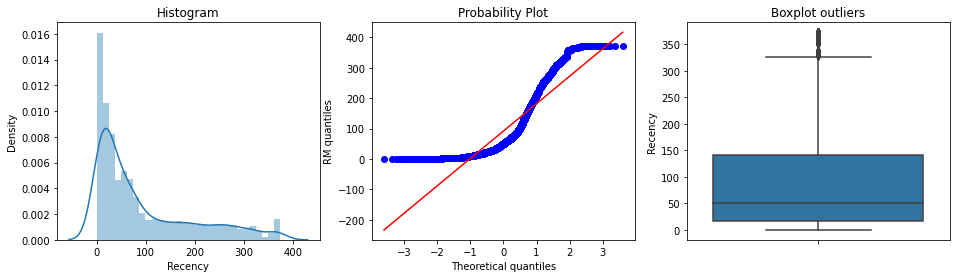

In [27]:
# Variable Recency   

diagnostic_plots(RFM_df, 'Recency')

C:\Users\ALEX\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


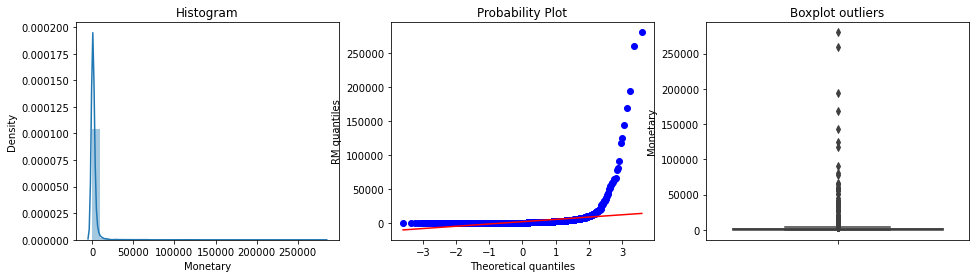

In [28]:
# Variable Monetary

diagnostic_plots(RFM_df, 'Monetary')

C:\Users\ALEX\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


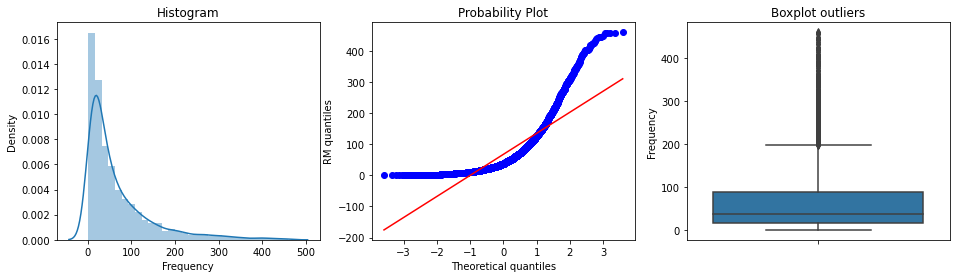

In [205]:
# Variable Frequency

diagnostic_plots(RFM_df, 'Frequency')

Efectivamente, **existen outilers en las 3 variables del RFM**. Al tener todas una distribuición sesgada hacia la derecha (principalmente `Monetary`y `Frequency`) definiremos la siguiente función para eliminar lous outilers.

In [30]:
def find_skewed_boundaries(df, variable, distance):

    IQR = df[variable].quantile(0.95) - df[variable].quantile(0.05)

    lower_boundary = df[variable].quantile(0.95) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.05) + (IQR * distance)

    return upper_boundary, lower_boundary

Establecemos los límites de cada variable.

In [31]:
# De Recency

Recency_upper_limit, Recency_lower_limit = find_skewed_boundaries(RFM_df, 'Recency', 1.5)


# De Monetary

Monetary_upper_limit, Monetary_lower_limit = find_skewed_boundaries(RFM_df, 'Monetary', 1.5)


# De Frequency 

Frequency_upper_limit, Frequency_lower_limit = find_skewed_boundaries(RFM_df, 'Frequency', 1.5)

Eliminamos los outliers.

In [32]:
outliers_Recency = np.where(RFM_df['Recency'] > Recency_upper_limit, True,
                       np.where(RFM_df['Recency'] < Recency_lower_limit, True, False))
outliers_Monetary = np.where(RFM_df['Monetary'] > Monetary_upper_limit, True,
                       np.where(RFM_df['Monetary'] < Monetary_lower_limit, True, False))
outliers_Frequency = np.where(RFM_df['Frequency'] > Frequency_upper_limit, True,
                       np.where(RFM_df['Frequency'] < Frequency_lower_limit, True, False))

In [33]:
RFM_df = RFM_df.loc[~(outliers_Recency + outliers_Monetary + outliers_Frequency)]

Comprobamos si los outliers más llamativos se han eliminado.

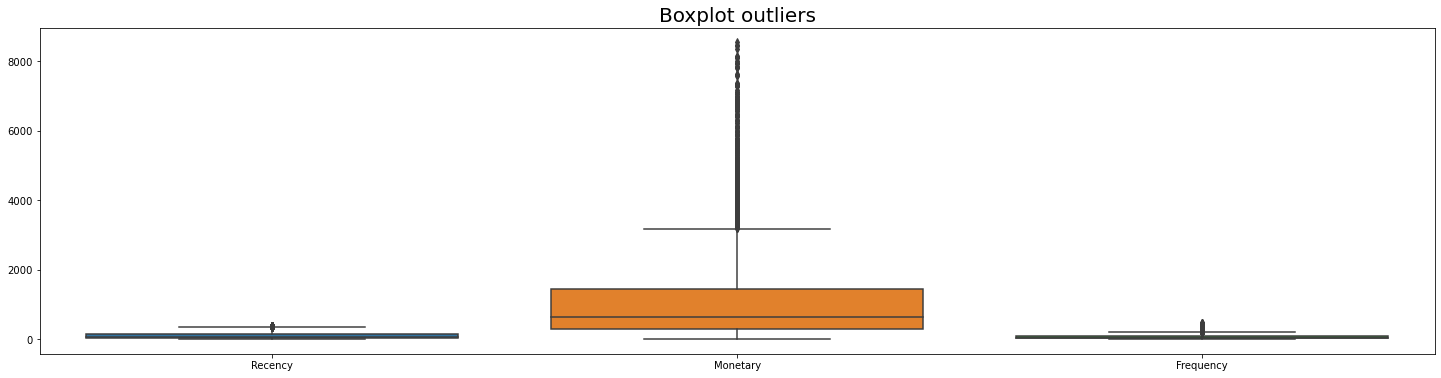

In [202]:
plt.figure(figsize=(25, 6))

sns.boxplot(data = RFM_df[['Recency', 'Monetary', 'Frequency']])
plt.title('Boxplot outliers', fontsize = 20)
plt.show()

Parece que al menos los más característicos han desaparecido. Cierto es que hay muchos valores destacables en `Monetary` pero al ser compra de mayoristas es normal que la cuantía de las transacciones destaque respecto a las otras dos variables. Examinamos ahora si se ha distorsionado mucho nuestro nuevo dataframe.

In [35]:
RFM_df.shape

(4158, 3)

Tan sólo hemos perdido un poco más del 4% de la muestra, por lo que **no se ha deformado mucho nuestro dataframe después de la limpieza de outliers**.

Dicho esto, es turno de hacer un **reescalado de las variables** con el fin de que desitribuyan todas ellas en la misma magnitud.

In [36]:
# Transformamos las variables

scaler = StandardScaler()
scaler.fit(RFM_df)

RFM_normal = scaler.transform(RFM_df)

In [37]:
# Creamos el nuevo dataframe con las variables reescaladas

RFM_normal = pd.DataFrame(RFM_normal)
RFM_normal

,0,1,2
0,-0.927827,2.309841,1.468231
1,-0.201952,0.471771,-0.468242
2,-0.768731,0.442738,0.070380
3,2.134768,-0.598288,-0.647783
4,-0.589748,0.990254,0.224271
...,...,...,...
4153,-0.221839,-0.715693,-0.750377
4154,1.806633,-0.710792,-0.737553
4155,0.842114,-0.783780,-0.776026
4156,-0.878110,-0.712657,-0.711904


Con esto ya completamos todo el procesamiento de los datos para poder continuar con el resto de este proyecto.

# 4. Construcción de un modelo de Clustering jerárquico

El primer paso para calcular el clustering jerárquico es **determinar la distancia existente entre todos los puntos (o clusters)**.

In [38]:
# Primero establecemos las 3 columnas

columns = RFM_normal.columns.values.tolist()

In [39]:
# Después elegimos el número de puntos con un nuevo dataset (en mi caso serán 800)

RFM_normal_select = RFM_normal.sample(800)

In [40]:
# Calculamos las distancias (optamos por el método de enlace de 'completo')

distances = linkage(RFM_normal_select[columns], 'complete')

La forma de visualizar un Clustering jerárquico es a través de un **dendograma**, esto es, un diagrama en forma de árbol.

In [41]:
# Definimos nuestra función del dendograma

def dendograma_plot (Z):
    plt.figure(figsize = (25,10))
    plt.title("Dendograma jerárquico para el Clustering", fontsize = 25)
    plt.xlabel("ID del cliente", fontsize = 17)
    plt.ylabel("Distancia", fontsize = 17)
    dendrogram (Z, leaf_rotation = 90., leaf_font_size = 10.0, truncate_mode = 'lastp') 

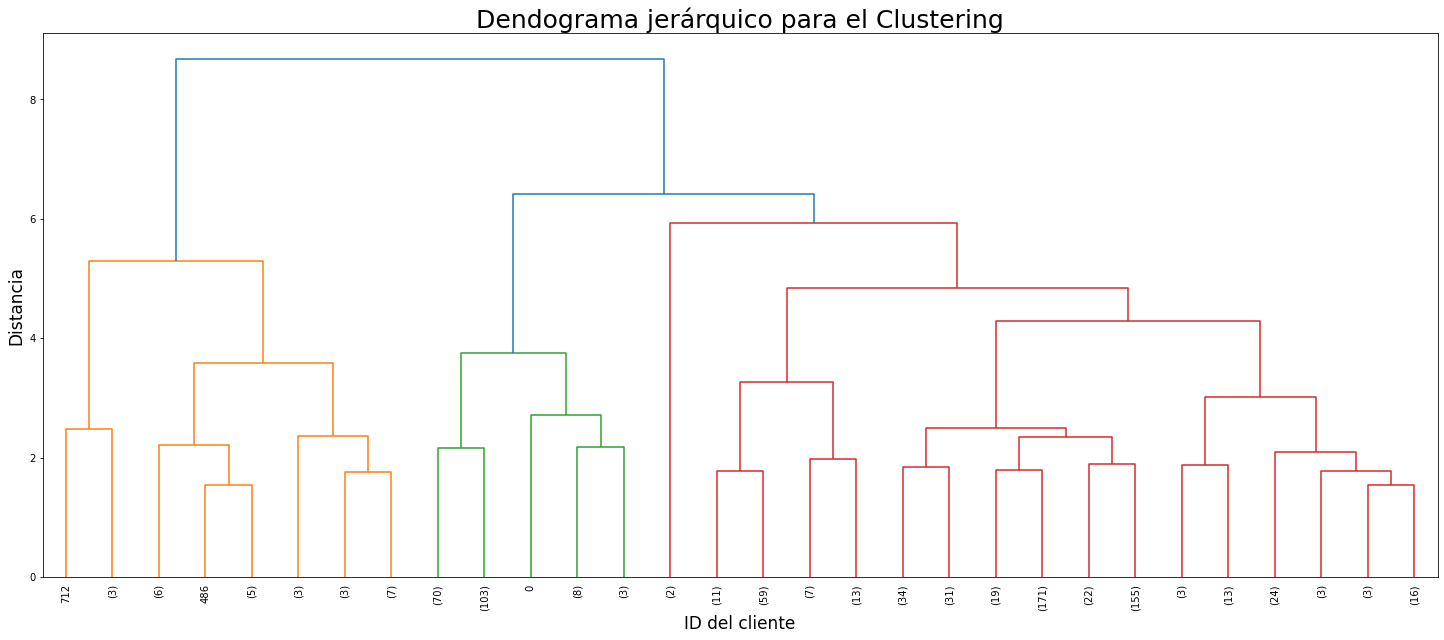

In [42]:
dendograma_plot(distances)

Aunque hay varios ID agrupados para una mejor visualización (si se ponía cada ID por separado era imposible identificarlos individualmente debido a la enorme muestra de clientes que hay), **podemos sacar estas observaciones**:

- Los usuarios con semejanzas al ID 6 tienen gustos similares a los ID con semejanzas al 5, 54, 2 y 11.

- Los usuarios con semejanzas al ID 11 les parece gustar lo mismo que a los ID con semejanzas, aparte del mencionado 6, al 30. Lo mismo ocurre con el los clientes similares al ID 5 que, además del 6, parecen entenderse mejor con los que tienen semejanzas al ID 9.

- Los usuarios con semejanzas al ID 59 parecen tener gustos análogos a los ID con semejanzas al 45 y 196.

# 5. Construcción de un modelo de K-Means

A la hora de construir un modelo de K-Means, tenemos dos opciones: **la Curva del Codo** y **el Coeficiente de Silhouette**. 

El primer paso es elegir el número de clusters óptimos con el fin de calcular las diferentes métricas y elegir la mejor. Decidimos por un número de clusters de 30, que era el número que nos ha devuelto antes el dendograma.

Empezando por la Curva del Codo, **nuestra finalidad es buscar el punto donde disminuye la pendiente pronunciada con la finalidad de determinar el número de cluster óptimo**.

In [97]:
# Creamos el array

RFM_array = np.array (RFM_normal)

Text(0.5, 1.0, 'Curva del codo')

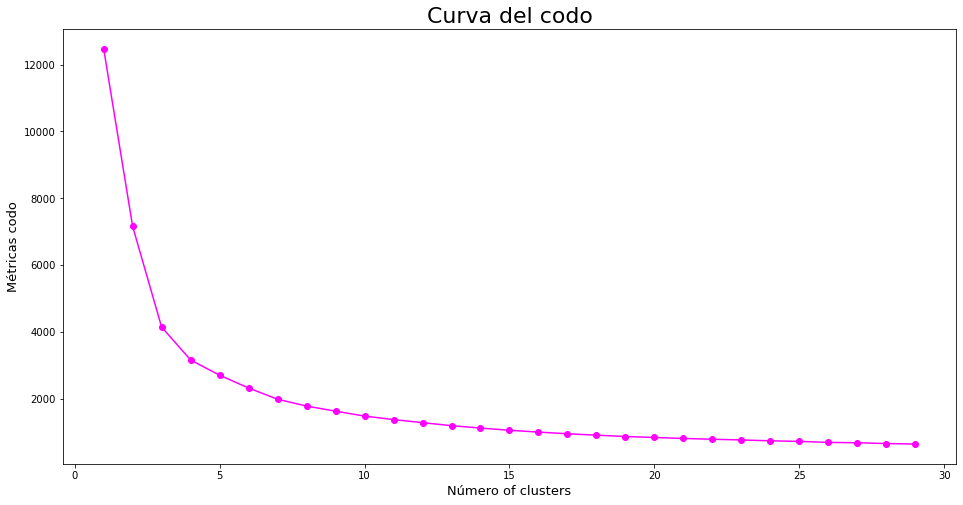

In [98]:
# Establecemos los 30 clusters

clusters_range = range(1,30)

# Creamos la lista (en blanco) para las métricas del codo

codo = []

# Calculamos las métricas

for c in clusters_range:
    kmeans = KMeans(n_clusters = c, random_state = 0).fit(RFM_array)
    codo.append(kmeans.inertia_)

# Hacemos la gráfico de la curva del codo

plt.figure(figsize = (16,8))
plt.plot(clusters_range,codo, marker ='o', color = 'magenta')
plt.xlabel('Número of clusters', fontsize = 13)
plt.ylabel('Métricas codo', fontsize = 13)
plt.title('Curva del codo', fontsize = 22)

Podemos ver ahora la evolución del Coeficiente de Silhouette para los distintos clusters y seleccionar después el mejor resultado como compromiso entre este coeficiente y la curva del codo. En este caso **se busca maximizar la distancia de cada uno de los puntos de un cluster al cluster más cercano**. 

Text(0.5, 1.0, 'Coeficiente de Silhouette')

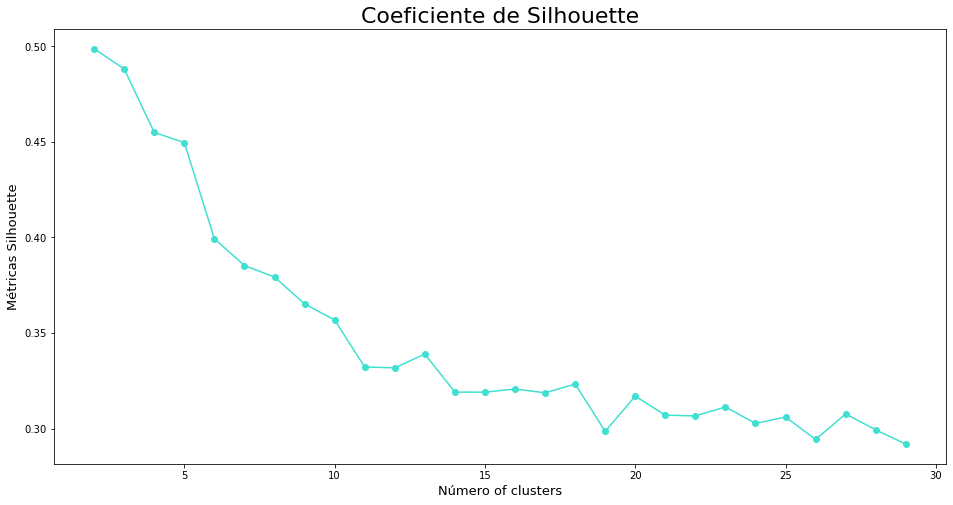

In [112]:
# Establecemos el rango

clusters_range = range(2, 30)

# Creamos la lista (en blanco) para el Coeficiente de Silhouette

results = []

# Calculamos las métricas

for c in clusters_range:
    clusterer = KMeans(n_clusters = c)
    cluster_labels = clusterer.fit_predict(RFM_array)
    silhouette_avg = silhouette_score(RFM_array, cluster_labels)
    results.append(silhouette_avg)

# Hacemos la gráfico de la curva del codo

plt.figure(figsize = (16,8))
plt.plot(clusters_range,results, marker = 'o', color = 'turquoise')
plt.xlabel('Número of clusters', fontsize = 13)
plt.ylabel('Distancia entre cada cluster', fontsize = 13)
plt.title('Coeficiente de Silhouette', fontsize = 22)

Si nos paramos a encontrar le equilibrio entre el codo de la Curva del Codo y el Coeficiente de Silhouette, podemos afirmar que **el número idóneo de clusters es 3 porque a partir de ahí la curva empieza a aplanarse**. Para complementar y hacer más rico este apartado, vamos a realizar una visualización 3D de los resultados así como indicar el principal producto de cada cluster. 

In [86]:
# Establecemos los 3 clusters y lo entrenamos

kmeans = KMeans(n_clusters = 3).fit(RFM_array)

# Centroides

centroids = kmeans.cluster_centers_

# Etiquetas

labels = kmeans.predict(RFM_array)

El **visionado en 3D**:

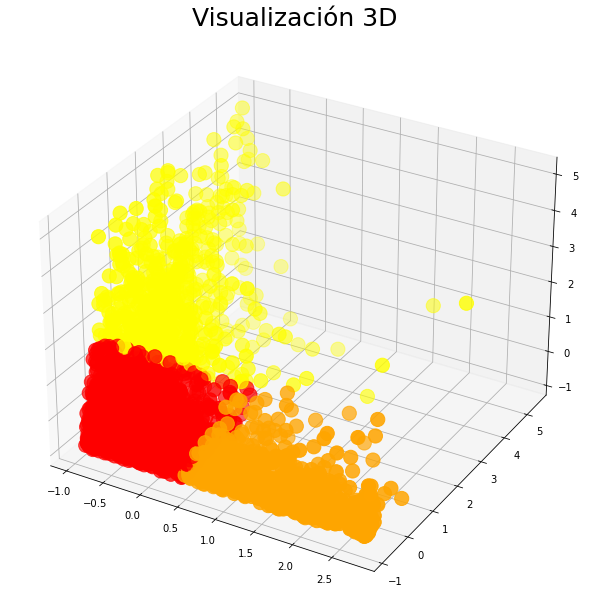

In [200]:
fig = plt.figure(figsize = (16,8))

ax = Axes3D(fig)
colores=['red','yellow','orange']
asignar = []
for row in labels: 
    asignar.append(colores[row])
plt.title("Visualización 3D", fontsize = 25)
ax.scatter(RFM_array[:,0],RFM_array[:,1],RFM_array[:,2] , c = asignar, s = 200)

La lista que indica **qué producto representa mejor cada uno de los 3 grupos**:

In [89]:
# Extraemos el índice a partir de la distancia de los centroides de cada uno de los registros

closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, RFM_array)

# Hacemos que se muestre el producto más demandado de cada grupo

productos = data_nona['Description'].values
for row in closest:
    print(productos[row])

TOILET SIGN OCCUPIED OR VACANT
RETRO COFFEE MUGS ASSORTED
JUMBO BAG SCANDINAVIAN PAISLEY


Teniendo en cuenta que estos son los productos más demandados, **la empresa deberá centrarse a la hora de promocionarlos para incentivar la compra a sus clientes**.

# 6. Visualizaciones gráficas

A lo largo de ese proyecto ya se ha estado justificando las diferentes conclusiones con visualizaciones o gráficos, por lo que no es necesario volver a mostrarlas. No obstante, sí parece interesante señalar las **correlaciones existentes entre las 3 variables del método RFM: `Recency`, `Monetary` y `Frecuency`**. Empecemos con un mapa de calor.

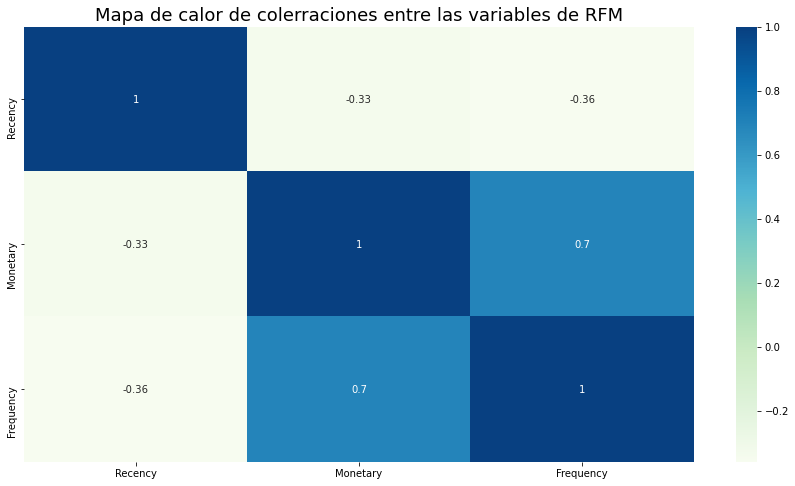

In [215]:
# Se crea una variable con la correlación del dataframe que contenía las 3 variables 

RFM_corr = RFM_df.corr()

# Se crea el mapa de calor o heatmap

plt.rcParams['figure.figsize'] = (16, 8)
ax = sns.heatmap(RFM_corr, cmap = "GnBu", annot = True)
ax.set_title("Mapa de calor de colerraciones entre las variables de RFM", fontsize = 18)
plt.show()

Aunque ningún valor llega al 0,8, si está cerca de existir una correlación positiva entre `Monetary` y `Frequency`. 

Para completar estas relaciones, mostraremos unos **mapas autoorganizados (o SOM)** de las 3 variables en cuestión.

In [108]:
# Con el dataset del RFM (ya limpio) cogemos una muestra (de 1000 en este caso)

RFM_df_sample = RFM_df.sample(1000)

Veamos los SOM de cada variable.

In [58]:
net = sps.SOMNet(20, 20, RFM_som_sample.values)
net.train()

Periodic Boundary Conditions inactive.
The weights will be initialized with PCA.
The map will be trained with the batch algorithm.
Training SOM... done!


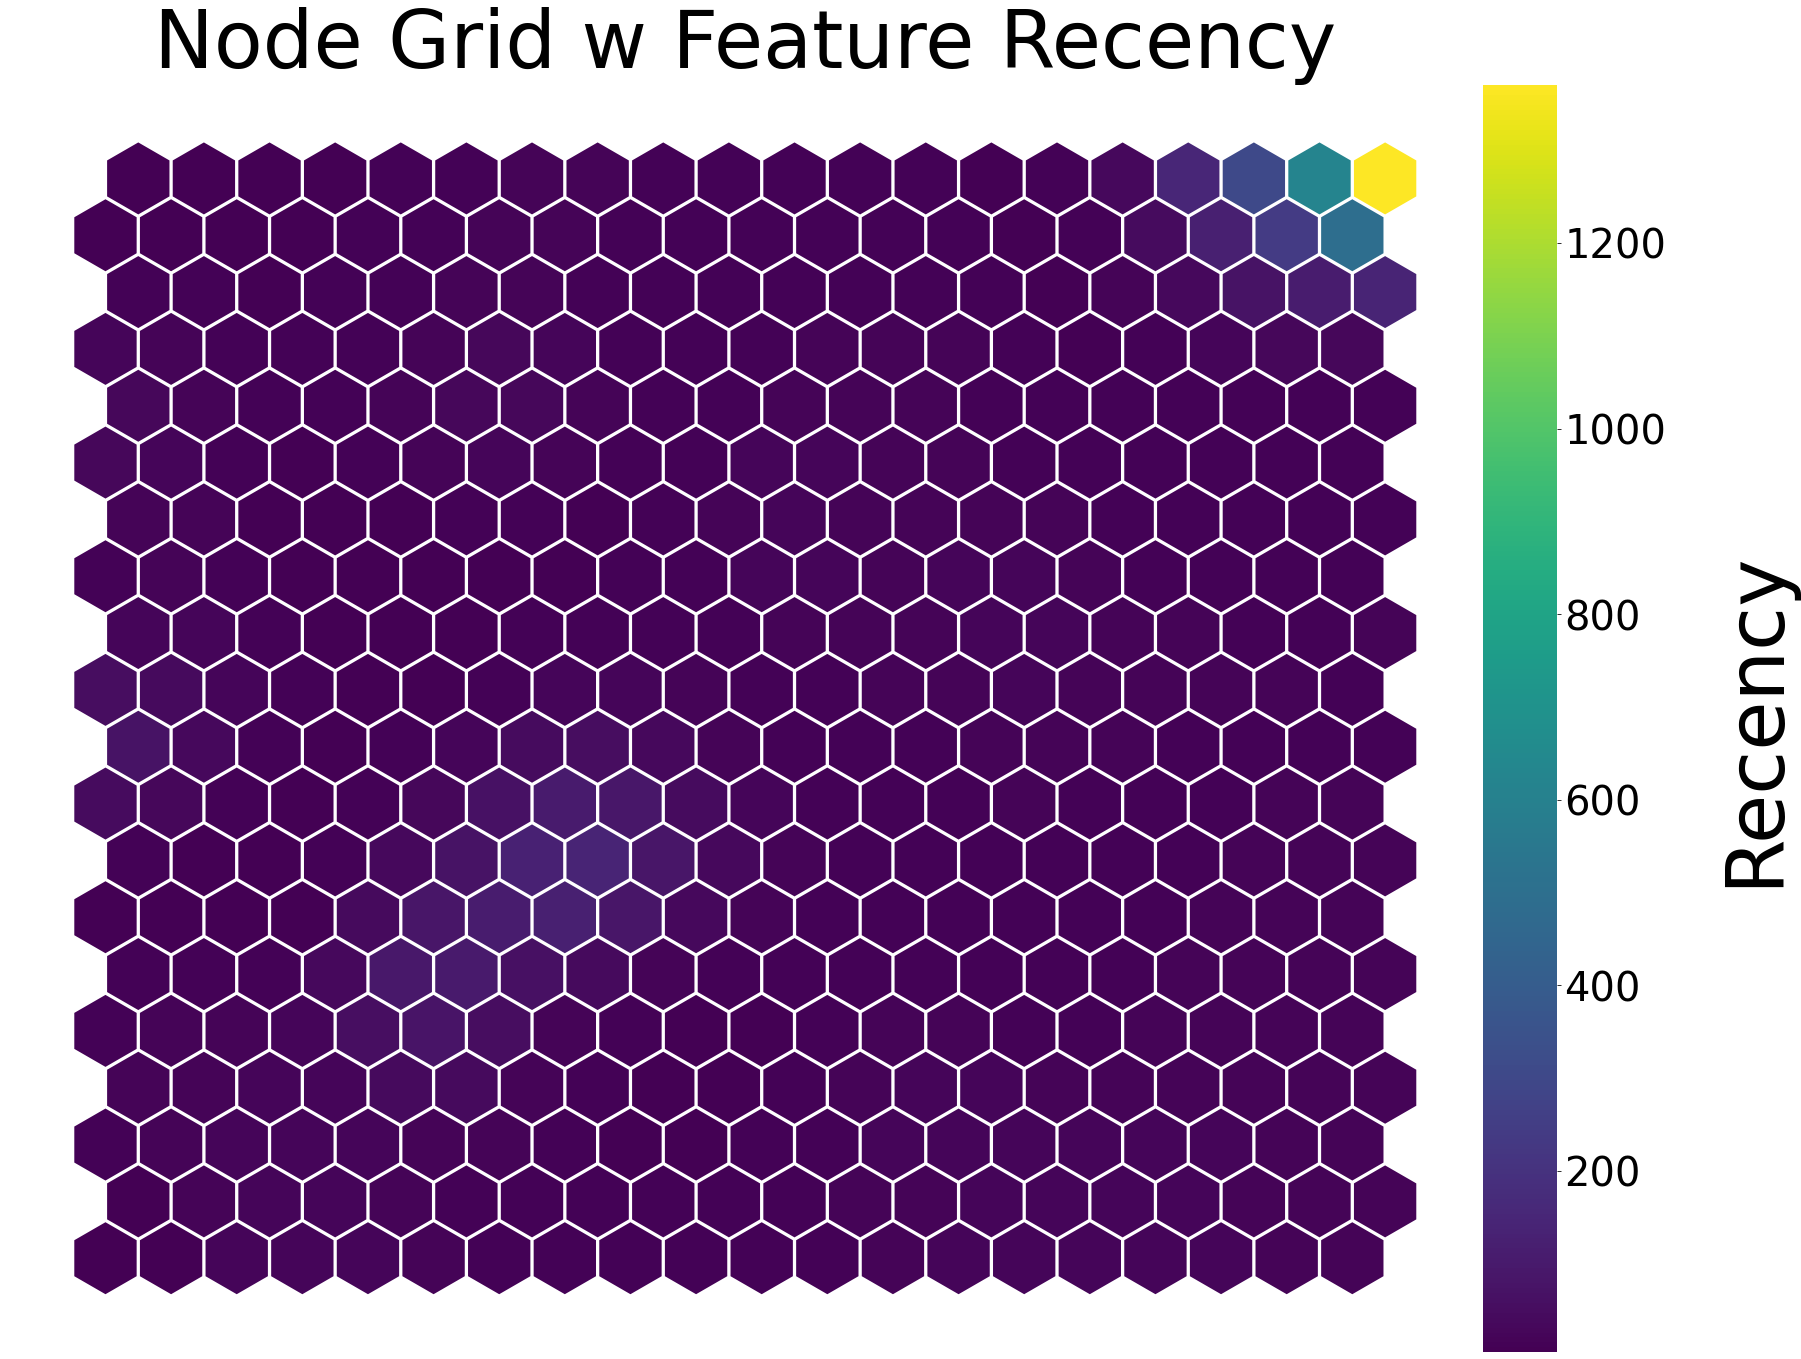

NameError: name 'printout' is not defined

In [106]:
# Para Recency

net.nodes_graph(colnum = 0, colname = 'Recency', show = True, print_out = False)

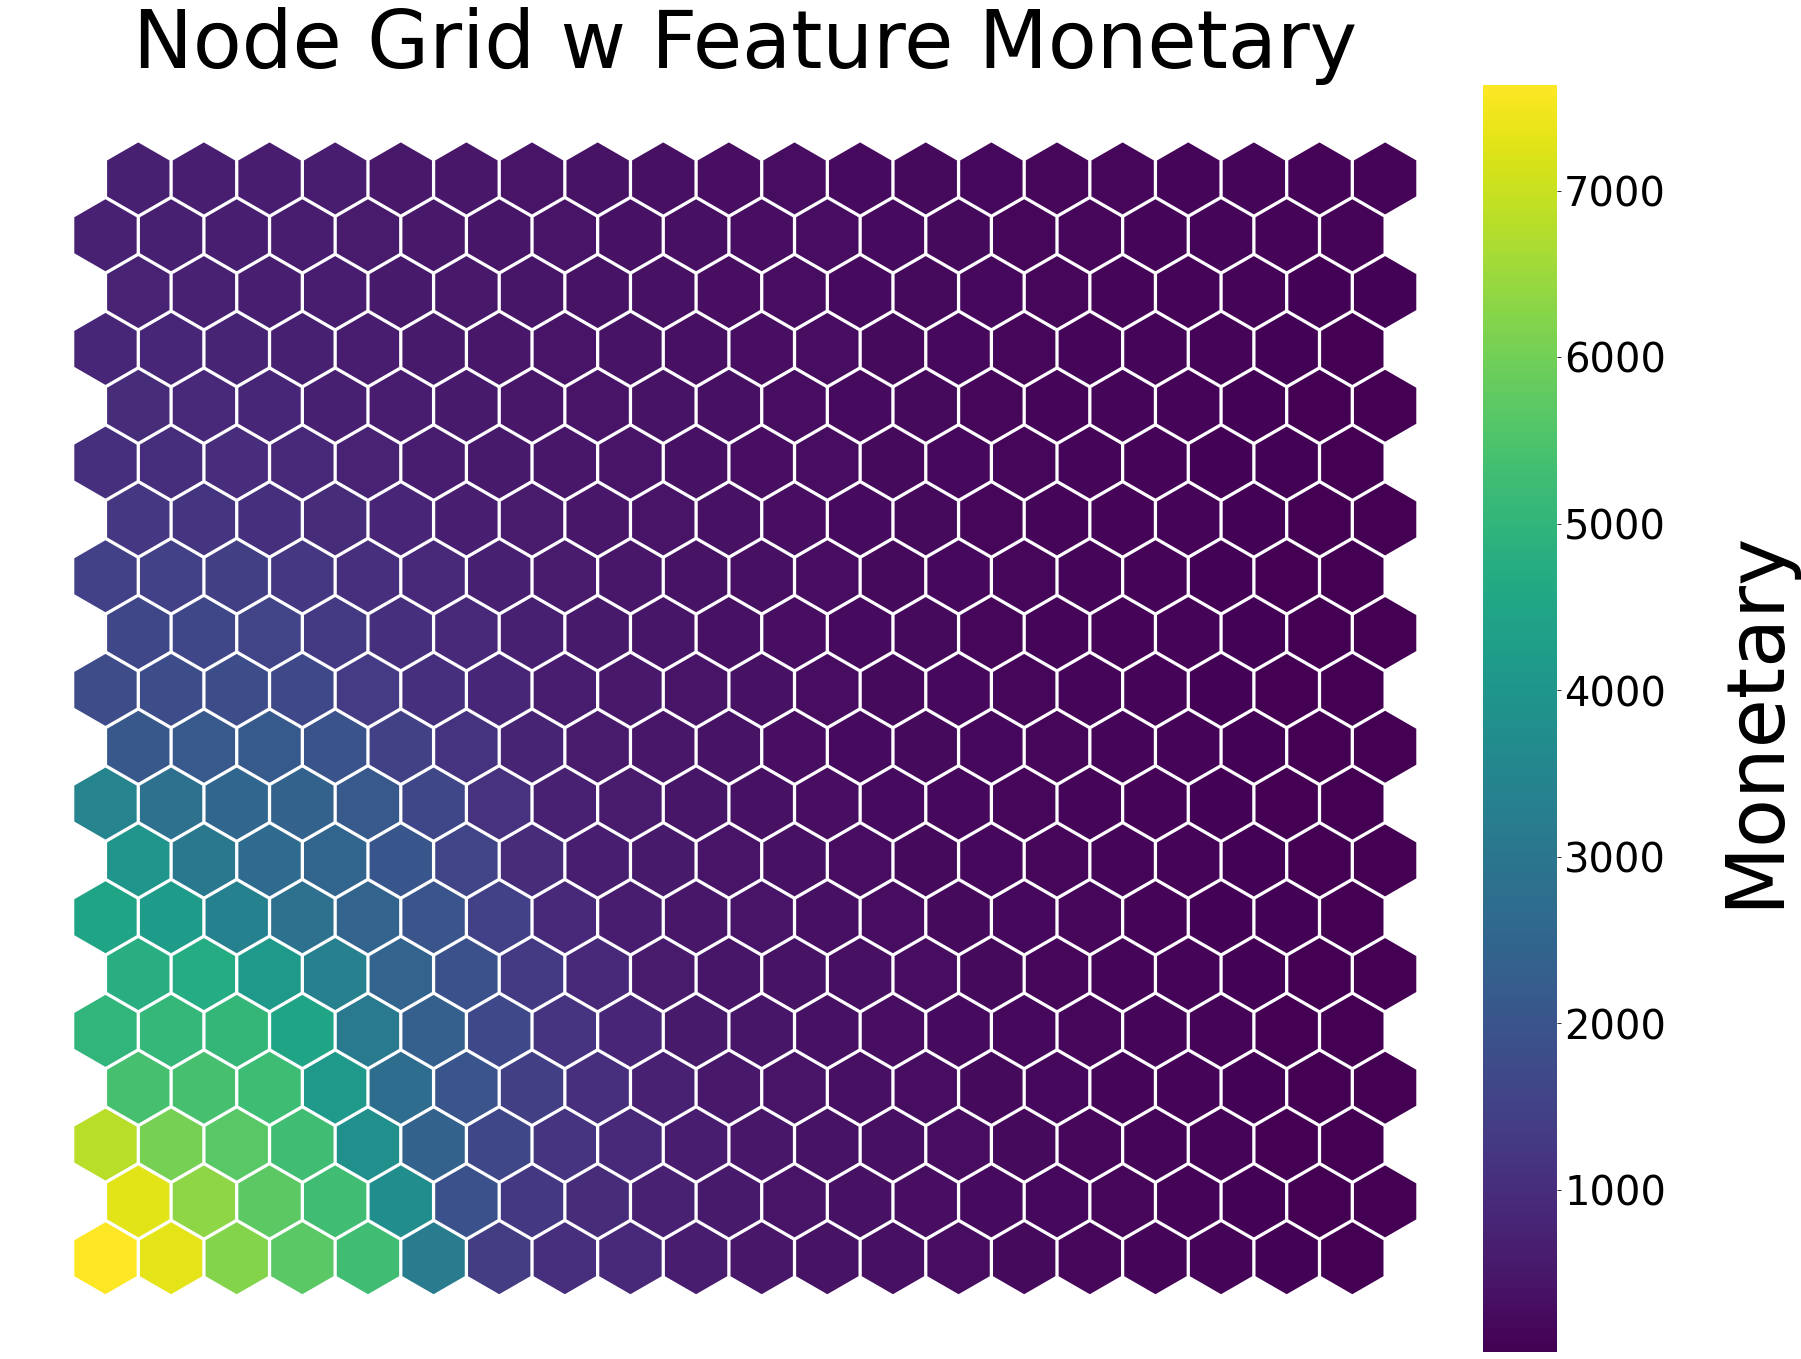

NameError: name 'printout' is not defined

In [109]:
# Para Monetary

net.nodes_graph(colnum = 1, colname = 'Monetary', show = True, print_out = False)

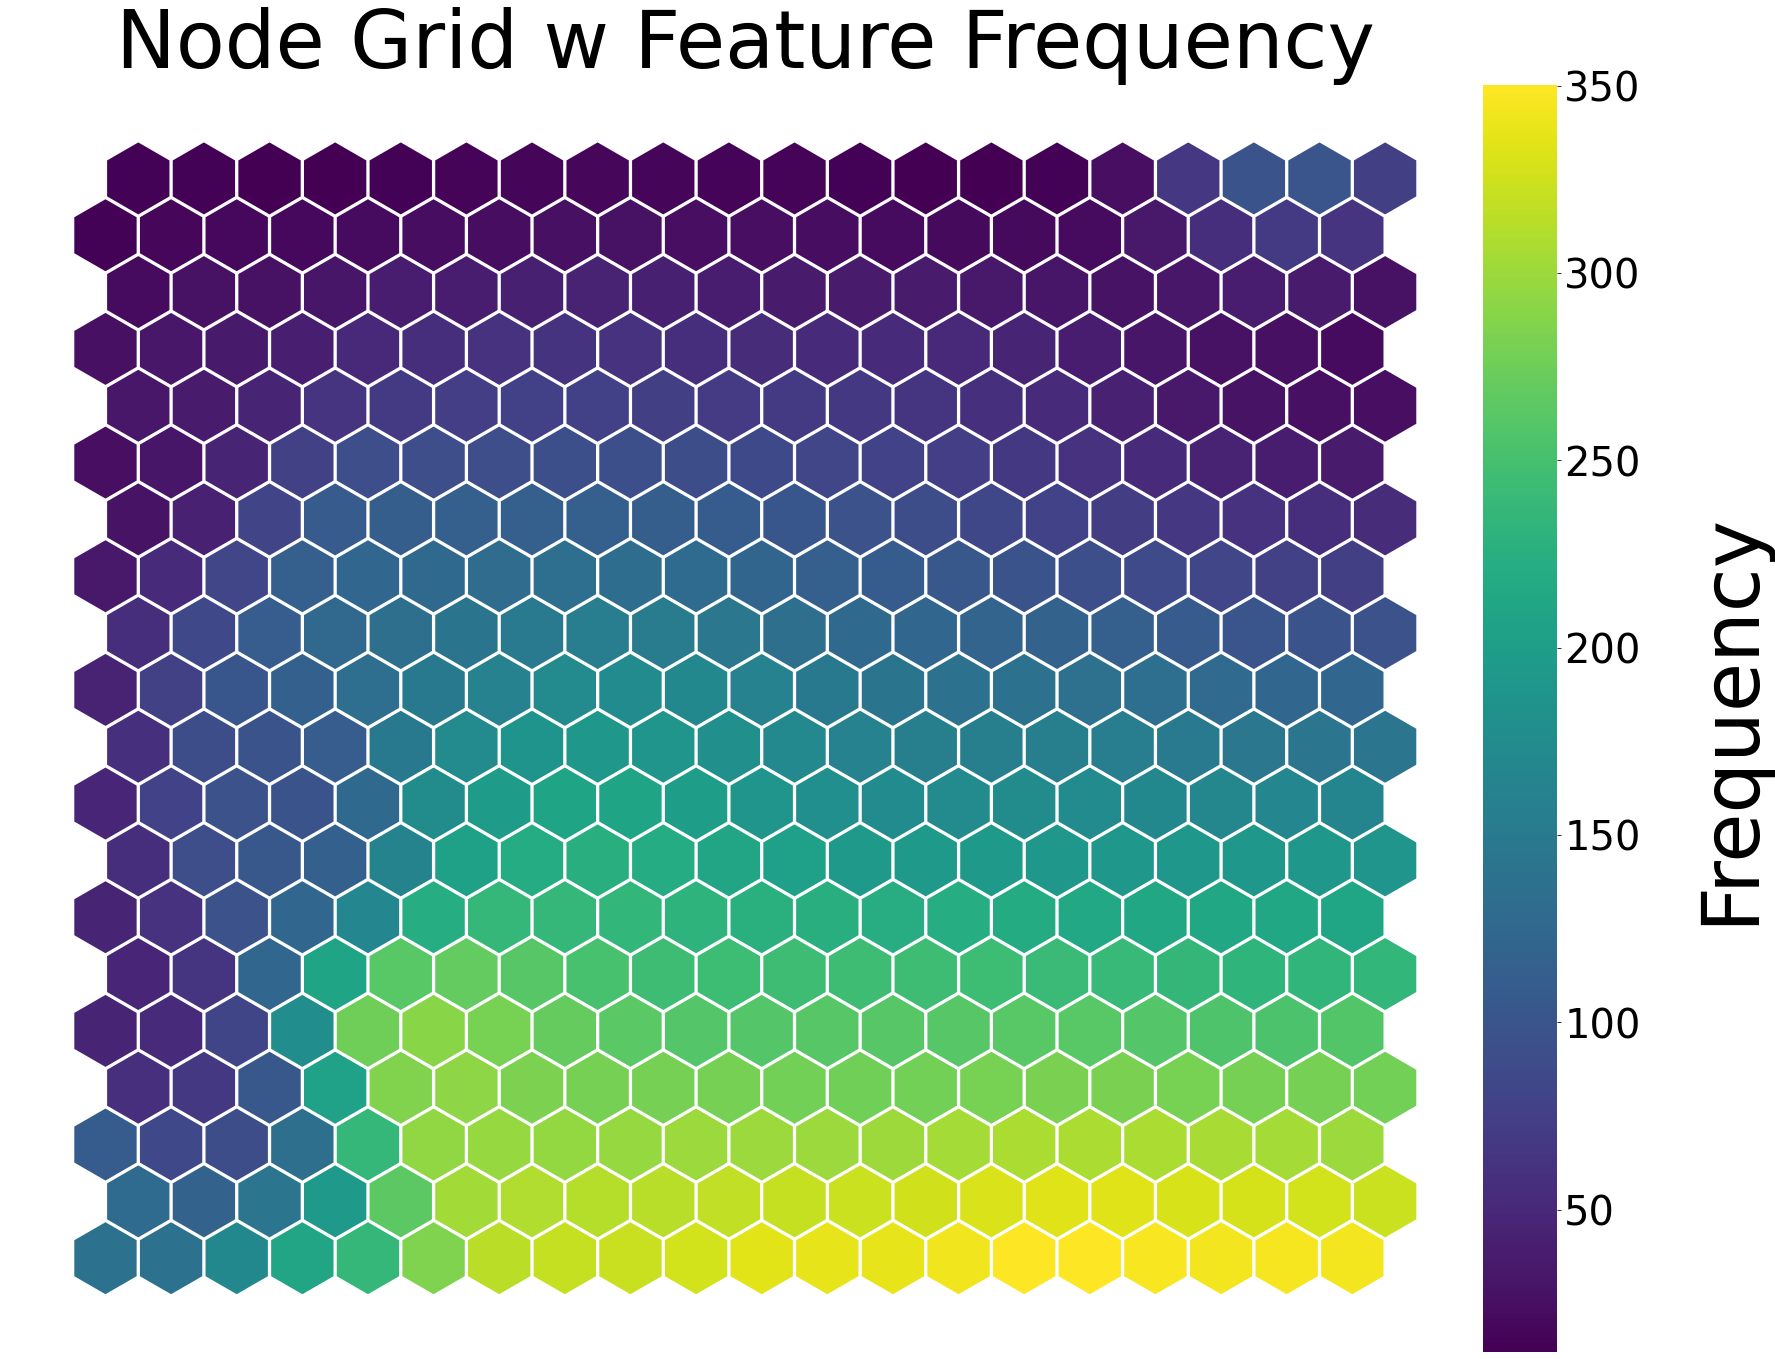

NameError: name 'printout' is not defined

In [110]:
# Para Frequency

net.nodes_graph(colnum = 2, colname = 'Frequency', show = True, print_out = False)

Habiendo visualizado estos 3 SOM, **podemos decir lo siguiente**:

- No parece afectar la variable `Recency` a las otras dos. Tiene sentido porque recordemos que para la fórmula del RFM elegimos el número mínimo de días desde la última compra de cada cliente así que al final muchos de estos clientes tienen una diferencia de días similares. Parece haber unos clientes que compran un poco más que los que apenas lo hacen con pocos días de diferencia entre una compra y otra, pero apenas tiene importancia.

- Siguiendo la lógica, los clientes que realizan más transacciones compran productos menos caros que otros clientes que, si bien compran con menor frecuencia, escogen productos de un precio más elevado. 

- Sin embargo, aquellos clientes que más gastan se encuentran en un punto intermedio entre los clientes más habituales y los que menos. Eso significa que aún siendo clientes potenciales, eligen productos con un precio medio-elevado. **Sin duda estos son los clientes los cuales la empresa tiene que centrarse en mayor medida**.

# 7. Dada la lista, realizar un ejercicio de reglas de asociación con el algoritmo APRIORI

A modo extra, finalmente se pide en este proyecto obtener una lista con todos los productos que se han comprado de manera conjunta. La finalidad será **intentar explicar este comportamiento de compra emparejado**. Para ello, emplearemos el algoritmo APRIORI.

In [176]:
# Cargamos y leemos el dataset

df_aso = pd.read_csv('dataset_ejercicio7.csv')

onehot = 

A continuación, por un lado, **extraemos los itemsets** fijando un soporte mínimo de **0.001** y especificamos que se use el nombre de la columna como el nombre del item. Por otro lado, **generamos las reglas** especificando una confianza mínima de **0.75**.

In [185]:
frequent_itemsets = apriori(df_aso, min_support=0.001, use_colnames=True)

rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.75)

rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Extra Salami or Feta),(Coffee),0.004015,0.478394,0.003275,0.815789,1.705267,0.001355,2.831575
1,(Keeping It Local),(Coffee),0.006656,0.478394,0.005388,0.809524,1.692169,0.002204,2.738431
2,"(Salad, Cake)",(Coffee),0.001373,0.478394,0.001057,0.769231,1.607944,0.000399,2.260292
3,"(Vegan mincepie, Cake)",(Coffee),0.001268,0.478394,0.001057,0.833333,1.741939,0.000450,3.129635
4,"(Cookies, Scone)",(Coffee),0.002007,0.478394,0.001585,0.789474,1.650258,0.000624,2.477628
5,"(Salad, Extra Salami or Feta)",(Coffee),0.001690,0.478394,0.001479,0.875000,1.829036,0.000670,4.172847
6,"(Sandwich, Hearty & Seasonal)",(Coffee),0.001479,0.478394,0.001268,0.857143,1.791709,0.000560,3.651241
7,"(Juice, Pastry)",(Coffee),0.002324,0.478394,0.001796,0.772727,1.615253,0.000684,2.295066
8,"(Toast, Pastry)",(Coffee),0.001585,0.478394,0.001373,0.866667,1.811617,0.000615,3.912044
9,"(Salad, Sandwich)",(Coffee),0.001902,0.478394,0.001585,0.833333,1.741939,0.000675,3.129635


Con esta información, podemos es filtrar aquello que nos interese. Por ejemplo, **seleccione con un `lift` superior a 1,7**.

In [186]:
rules[rules["lift"]>1.7]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Extra Salami or Feta),(Coffee),0.004015,0.478394,0.003275,0.815789,1.705267,0.001355,2.831575
3,"(Vegan mincepie, Cake)",(Coffee),0.001268,0.478394,0.001057,0.833333,1.741939,0.000450,3.129635
5,"(Salad, Extra Salami or Feta)",(Coffee),0.001690,0.478394,0.001479,0.875000,1.829036,0.000670,4.172847
6,"(Sandwich, Hearty & Seasonal)",(Coffee),0.001479,0.478394,0.001268,0.857143,1.791709,0.000560,3.651241
8,"(Toast, Pastry)",(Coffee),0.001585,0.478394,0.001373,0.866667,1.811617,0.000615,3.912044
9,"(Salad, Sandwich)",(Coffee),0.001902,0.478394,0.001585,0.833333,1.741939,0.000675,3.129635


Otra filtración sería **ordenar por orden descendente la información según la `confidence` y el `support`**.

In [195]:
rules.sort_values(["confidence", "support"], ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
5,"(Salad, Extra Salami or Feta)",(Coffee),0.001690,0.478394,0.001479,0.875000,1.829036,0.000670,4.172847
8,"(Toast, Pastry)",(Coffee),0.001585,0.478394,0.001373,0.866667,1.811617,0.000615,3.912044
6,"(Sandwich, Hearty & Seasonal)",(Coffee),0.001479,0.478394,0.001268,0.857143,1.791709,0.000560,3.651241
9,"(Salad, Sandwich)",(Coffee),0.001902,0.478394,0.001585,0.833333,1.741939,0.000675,3.129635
3,"(Vegan mincepie, Cake)",(Coffee),0.001268,0.478394,0.001057,0.833333,1.741939,0.000450,3.129635


Para terminar, respecto a las reglas creadas anteriormente, visualizamos las observaciones:

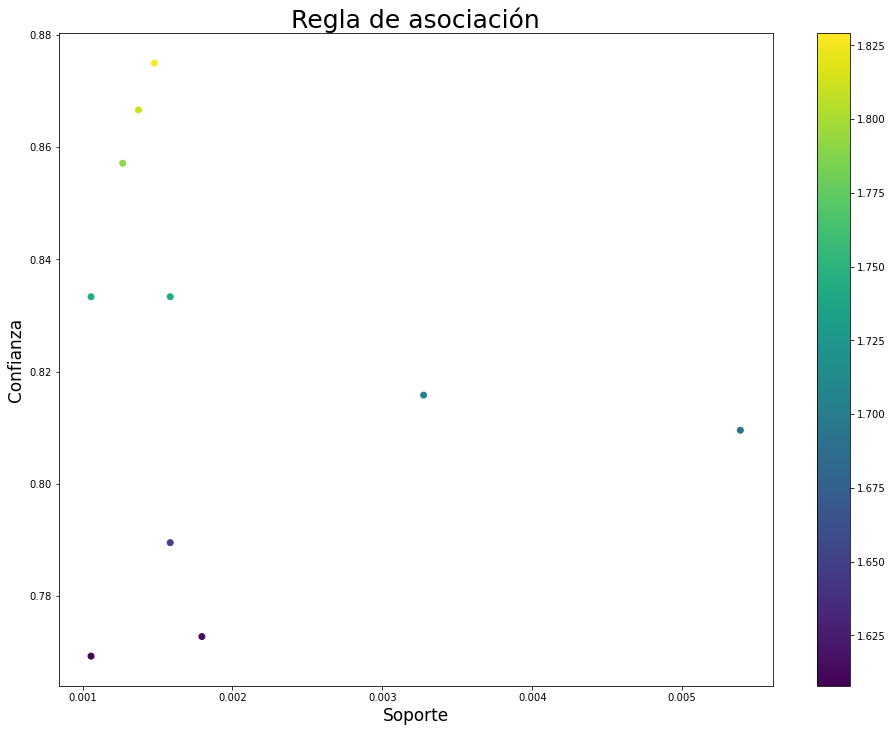

In [204]:
plt.figure(figsize=(16, 12))
sc = plt.scatter(rules["support"], rules["confidence"], c=rules["lift"], cmap = 'viridis')
plt.title("Reglas de asociación", fontsize = 25)
plt.colorbar(sc)
plt.xlabel("Soporte", fontsize = 17)
plt.ylabel("Confianza", fontsize = 17)
plt.show()

El resultado, más allá de cualquier filtración que podamos hacer, es claro: **la empresa debería recomendar el café independientemente de la intención de compra que tenga**. Esto es así porque se puede observar que los productos comprados antes del café por los clientes es muy variado y no parece seguir ninguna relación.

A modo resumen, las conclusiones finales son:

- El número de clientes es elevado para poder realizar un estudio individual de cada uno. No obstante, gracias el dendograma, podemos llegar a juntar usuarios con gustos similares. **Parecen interesantes los clientes con semejanzas al cliente de ID 6** pues son los que más preferencias parecidas tienen con otros usuarios.

- Teniendo en cuenta los SOM respecto a la RFM, hay que tener especial atención con **aquellos clientes semi-potenciales que escogen productos de precio medio-elevado**, pues van a ser el grupo de usuarios que más beneficios van a dar en la empresa.

- Respecto a los productos, a partir del modelo K-Means, sabemos que **`Toilet sign occupied or vacant`, `Retro coffee mugs assorted` y `Jumbo bag scandinavian paisley` están entre los destacados**. Tenemos que resaltar ese segundo producto relacionado con el café ya que nos confirma el resultado de las reglas de asociación, haciendo que sumemos a esta lista un producto más: **el café (`Coffee`)**.

Espero que les haya sido de ayuda este informe y deseo que sigan contando con mis servicios en futuros análisis de datos de la compañia.